# Using enterprise to analyze PTA data

In this notebook you will learn:
* How to use `enterprise` to interact with NANOGrav data,
* How to setup an analysis of individual pulsar white noise properties,
* How to post-process your results.

If you are interested in working through this notebook, but do not want to install the software, we have prepared a related Google Colab notebook: https://colab.research.google.com/drive/1xft6F9nyoEHUVn1LbW-0qgXiiKDJuR3X#scrollTo=7kVh83a8w36s

By copying this notebook, you can install the software to your own Google Colab account and run the software without installation on your computer.

# Load packages and modules

In [1]:
from __future__ import division

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

## Get par, tim, and noise files

In [2]:
psrlist = None # define a list of pulsar name strings that can be used to filter.

In [3]:
datadir = './data'
if not os.path.isdir(datadir):
    datadir = '../data'
print(datadir)

../data


In [4]:
psrstring = 'J1853+1303'  # name of the pulsar

parfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'par'), psrstring + '*')))
timfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'tim'), psrstring + '*')))

# filter
if psrlist is not None:
    parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0] in psrlist]
    timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0] in psrlist]

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile... 
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv3.gls.par' not in x]

In [5]:
# if these are empty, then your data directory is wrong.
print(parfiles)
print(timfiles)

['../data/par/J1853+1303_NANOGrav_12yv3.gls.par']
['../data/tim/J1853+1303_NANOGrav_12yv3.tim']


## Load into `Pulsar` class list

* The `enterprise` Pulsar class uses `libstempo` to read in `par` and `tim` files, then stores all pulsar data into a `Pulsar` object. This object contains all data and meta-data needed for the ensuing pulsar and PTA analysis. You no longer need to reference the `par` and `tim` files after this cell.
* Note below that you can explicitly declare which version of the JPL solar-system ephemeris model that will be used to compute the Roemer delay between the geocenter and the barycenter (e.g. `DE438`). Otherwise the default values will be taken from the `par` files. Explicitly declaring the version here is good practice.
* You can also explicitly set the clock file to a version of `BIPM`, e.g. `BIPM(2018)`. This is less important, and you can let the code take the value from the `par` file.
* When you execute the following cell, you will get warnings like `WARNING: Could not find pulsar distance for PSR ...`. Don't worry! This is expected, and fine. Not all pulsars have well constrained distances, and will be set to `1 kpc` with a `20%` uncertainty.

### Read par and tim files into `enterprise` `Pulsar` objects

In [6]:
psrs = []
for p, t in zip(parfiles, timfiles):
    if psrstring in p:
        psr = Pulsar(p, t, ephem='DE438', clk='BIPM(2018)')
        psrs.append(psr)

In [56]:
## Get parameter noise dictionary (for comparison in this notebook)
noise_ng12 = datadir + '/channelized_12p5yr_v3_full_noisedict.json'

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

# Single pulsar analysis
* `enterprise` is structured so that one first creates `parameters`, then `signals` that these `parameters` belong to, then finally a `model` that is the union of all `signals` and the `data`.
* We will show this explicitly below, then introduce some model shortcut code that will make your life easier.
* We test on `J1853+1303`.

In [7]:
psr = [p for p in psrs if p.name == 'J1853+1303'][0]

In [8]:
# find the maximum time span to set red-noise/DM-variation frequency sampling
tmin = psr.toas.min()
tmax = psr.toas.max()
Tspan = np.max(tmax) - np.min(tmin)
print(Tspan / 365.25 / 24 / 60 / 60)  # time span of data in years

5.979596068858798


In [9]:
# define selection by observing backend
# there will be separate white noise parameters for each observing backend
# since NANOGrav began taking data, there have been two generations of backends
# (ASP and PUPPI at Arecibo, GASP and GUPPI at Green Bank)
selection = selections.Selection(selections.by_backend)

## Create parameters
* White noise parameters are varied for each pulsar and then set to their most likely values when running the analyses for the entire array.
* These parameters are saved as a dictionary to a `.json` noisefile or set of noisefiles for easy access.
* Here we go through what one of these white noise searches looks like in long form, and then we will use shortcuts to do the same thing.

In [10]:
# white noise parameters
white_vary = True
if white_vary:
    efac = parameter.Uniform(0.01, 10.0)
    equad = parameter.Uniform(-8.5, -5)
    ecorr = parameter.Uniform(-8.5, -5)
else:
    efac = parameter.Constant() 
    equad = parameter.Constant() 
    ecorr = parameter.Constant() # we'll set these later with the params dictionary

# red noise parameters
log10_A = parameter.Uniform(-20, -11)
gamma = parameter.Uniform(0, 7)

## Create signals

In [11]:
# white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

# timing model
tm = gp_signals.TimingModel(use_svd=True) # stabilizing timing model design matrix with SVD

## Piece the full model together

In [12]:
# full model
s = ef + eq + ec + rn + tm

In [13]:
# intialize a single-pulsar pta model
# see how the "model" acts on the "pulsar" object...
pta = signal_base.PTA(s(psr))

In [15]:
len(pta.params)  # the higher this number is, the longer the model will take to  
                 # sample and the more samples it will require

14

## Draw initial sample from model parameter space

In [16]:
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)

## Setup sampler (simple, with no tricks)

In [17]:
# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2) # helps to tune MCMC proposal distribution

# where chains will be written to
outdir = '../chains_singlepsr_wn_{}/'.format(str(psr.name))

# sampler object
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov,
                 outDir=outdir, 
                 resume=False)

## Sample the parameter space

This will take around an **hour**. Note that the normal runs typically use 5e6 samples. For the sake of finishing the sampling process more quickly, we use a tenth of that for this tutorial. The sampling process can be interrupted and resumed at a later time by changing to `resume=True` in the above cell.

In [29]:
# sampler for N steps
N = int(3e5)

# SCAM = Single Component Adaptive Metropolis
# AM = Adaptive Metropolis
# DE = Differential Evolution
## You can keep all these set at default values
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

Finished 3.33 percent in 89.806132 s Acceptance rate = 0.5711Adding DE jump with weight 50
Finished 99.67 percent in 3156.432408 s Acceptance rate = 0.228555
Run Complete


## Simple post-processing

In [45]:
chain = np.loadtxt(outdir + 'chain_1.txt')
# experiment with burn-in
pct = 0.3 # percent of the chain to toss
burn = int(pct * chain.shape[0])

In [46]:
# Find column of chain file corresponding to a parameter
ind = list(pta.param_names).index(psrstring + '_red_noise_log10_A')

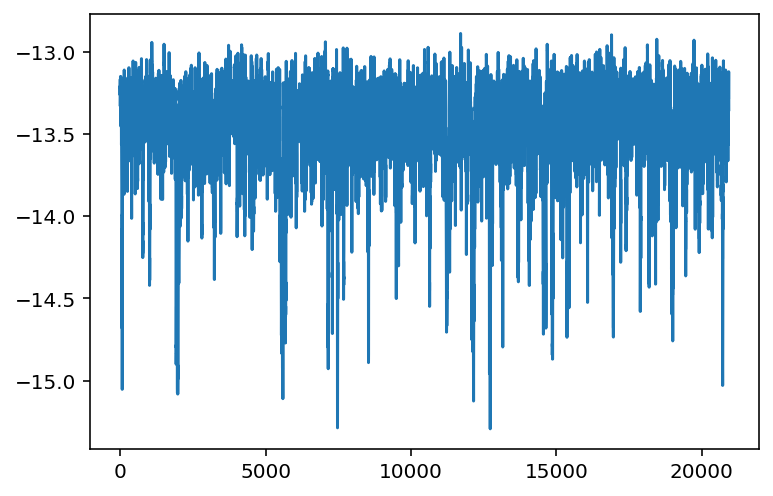

In [47]:
# Make trace-plot to diagnose sampling
plt.plot(chain[burn:, ind])

* A well sampled chain should look more like a **fuzzy** caterpillar than a **skinny worm**.
* This one appears to be pretty well sampled.

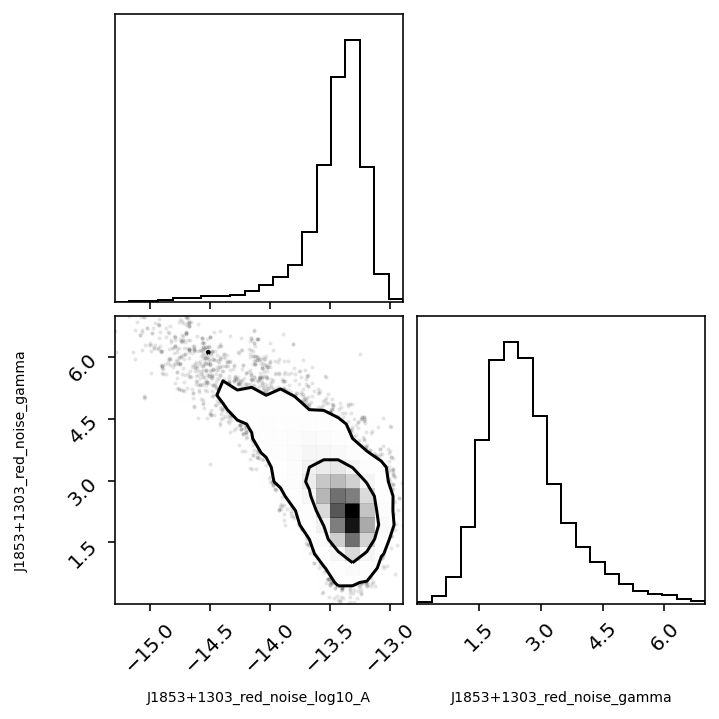

In [51]:
# Make 2d histogram plot for red noise
ind_redA = list(pta.param_names).index(psrstring + '_red_noise_log10_A')
ind_redgam = list(pta.param_names).index(psrstring + '_red_noise_gamma')
fig = corner.corner(chain[burn:, [ind_redA, ind_redgam]], 
                    labels=[psrstring + '_red_noise_log10_A',
                            psrstring + '_red_noise_gamma'],
                            label_kwargs={"fontsize": 7},
                            levels=[0.68,0.95]);

In [94]:
# compare red noise amplitude
print('params_max =',
      params['J1853+1303_red_noise_log10_A'])  # from the noise file
hist = np.histogram(chain[burn:, [ind_redA]],
                          bins=70,
                          density=False)
max_ind = np.argmax(hist[0])
print('our_max =', hist[1][max_ind])  # from our computation

params_max = -13.39744115688417
our_max = -13.370956921573454


In [93]:
# compare red noise gamma
print('params_max =',
      params['J1853+1303_red_noise_gamma'])  # from the noise file
hist = np.histogram(chain[burn:, [ind_redgam]],
                          bins=70,
                          density=False)
max_ind = np.argmax(hist[0])
print('our_max =', hist[1][max_ind])  # from our computation

params_max = 2.4720178742938748
our_max = 2.201613396019765


* The most likely values can be found in `channelized_12p5yr_v3_full_noisedict.json` in the `data` folder.
* Since we imported them earlier we can also find them in the `params` dictionary as shown above. 
* By direct comparison, we can see that we get pretty close - within one bin.
* Note that this is slightly dependent on the number of `bins` in our `np.histogram`.


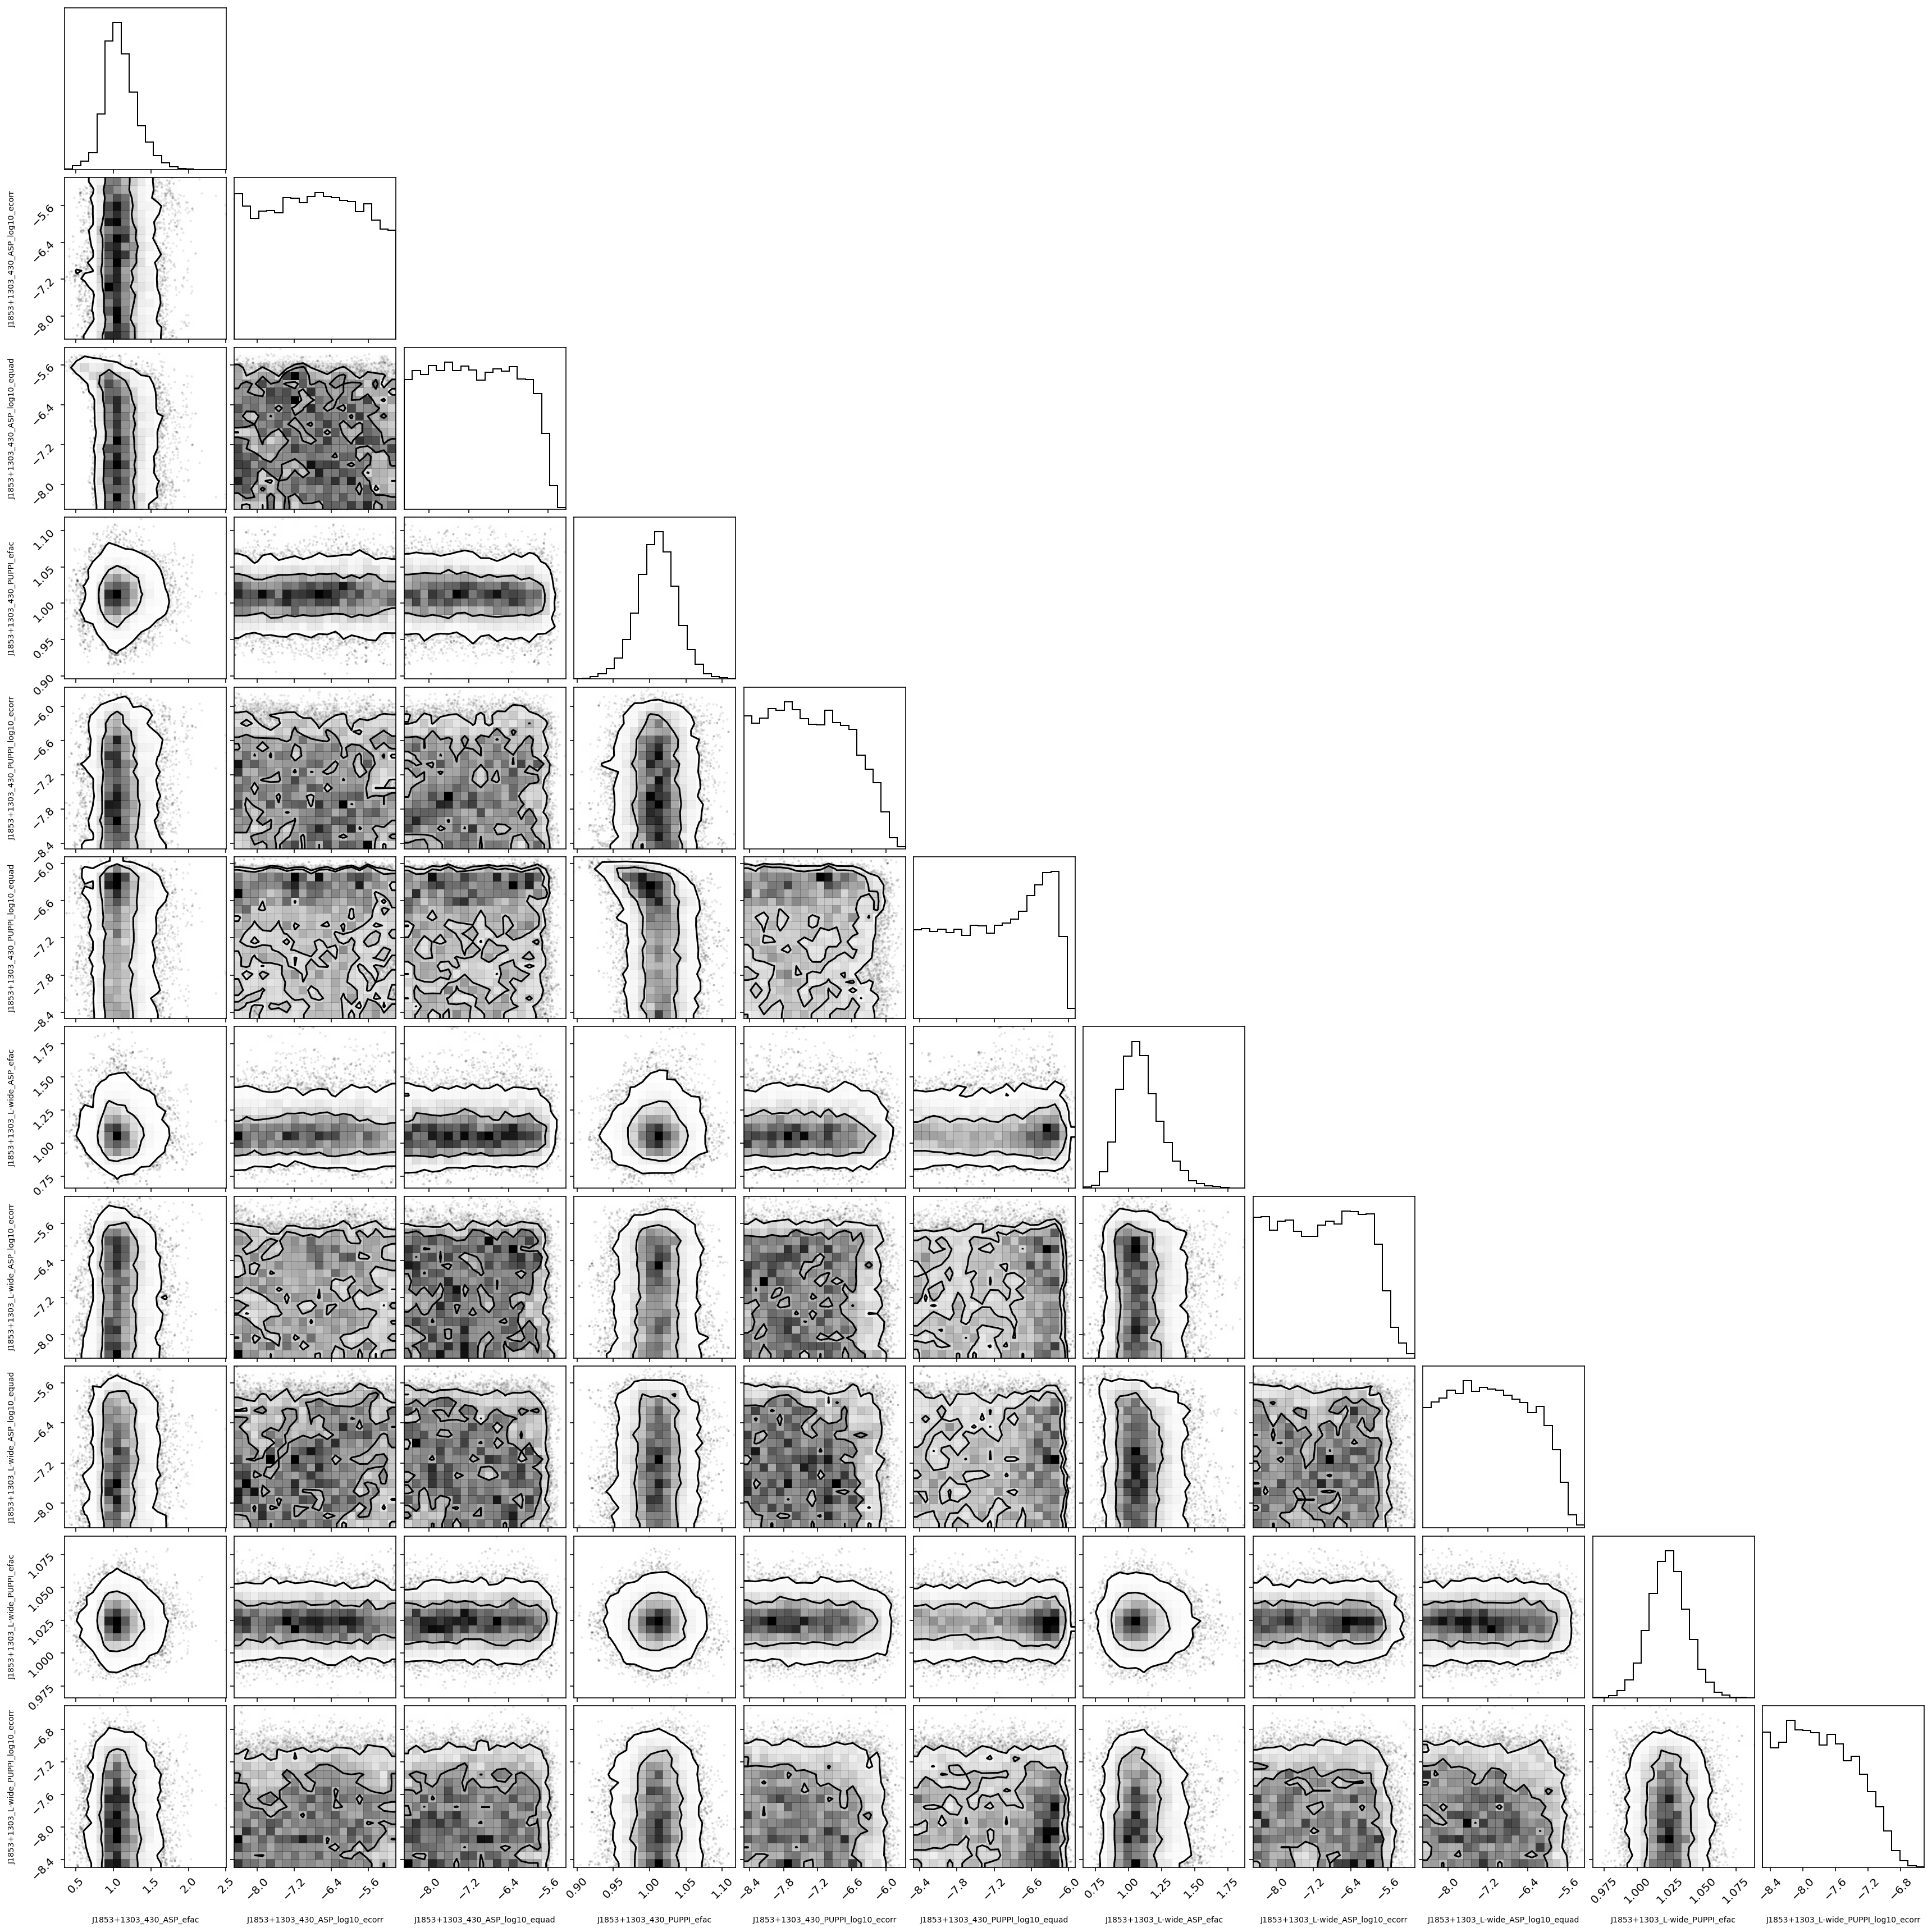

In [54]:
# Make 2d histogram plot for white noise
ind_end = list(pta.param_names).index(psrstring + '_L-wide_PUPPI_log10_equad')
fig = corner.corner(chain[burn:, np.arange(ind_end)],
                    labels=list(pta.param_names[0:ind_end]),
                    label_kwargs={"fontsize": 7},
                    levels=[0.68,0.95]);

In [106]:
# check the white noise parameters against the noisefile
for par in list(pta.param_names[0:ind_end]):
    print('{}_max ='.format(par), params[par])
    hist = np.histogram(chain[burn:, pta.param_names.index(par)],
                          bins=70,
                          density=False)
    max_ind = np.argmax(hist[0])
    print('our_max =', hist[1][max_ind])  # from our computation
    print()

J1853+1303_430_ASP_efac_max = 1.078315248869886
our_max = 0.9942741000179247

J1853+1303_430_ASP_log10_ecorr_max = -6.786182491593548
our_max = -8.449986840140882

J1853+1303_430_ASP_log10_equad_max = -7.0316537983149825
our_max = -7.569764446703496

J1853+1303_430_PUPPI_efac_max = 1.0109631461154447
our_max = 1.0102559976701522

J1853+1303_430_PUPPI_log10_ecorr_max = -7.344038425120731
our_max = -7.68834526431438

J1853+1303_430_PUPPI_log10_equad_max = -7.1227376684628645
our_max = -6.304552903416573

J1853+1303_L-wide_ASP_efac_max = 1.0786110947865066
our_max = 1.0421579388679012

J1853+1303_L-wide_ASP_log10_ecorr_max = -7.0135381645815835
our_max = -8.40036344951052

J1853+1303_L-wide_ASP_log10_equad_max = -7.1547369968726455
our_max = -7.71368430266893

J1853+1303_L-wide_PUPPI_efac_max = 1.0235843088915801
our_max = 1.0205504994454773

J1853+1303_L-wide_PUPPI_log10_ecorr_max = -7.804157398025932
our_max = -8.18750077880361



* Again, some of these are exactly right and several of them are in the next bin or two.
* Others have quite different values, but investigation shows that their posteriors are flat.

## Now, the easy way to do all of this

* Many of us have created shortcuts to carry out these tasks. You will find them in `enterprise_extensions`: https://github.com/nanograv/enterprise_extensions.
* Note that if you decide to do it this way on your own, you will still need the imported packages above.
* Setting the data directory and creating the `Pulsar` object is also required.

In [107]:
import enterprise_extensions
from enterprise_extensions import models, sampler

In [108]:
# Create a single pulsar model
pta = models.model_singlepsr_noise(psr, red_var=True, psd='powerlaw', 
                                   noisedict=None, white_vary=True, 
                                   tm_svd=True, components=30)

In [109]:
len(pta.params)
pta.params

[J1853+1303_430_ASP_efac:Uniform(pmin=0.01, pmax=10.0),
 J1853+1303_430_ASP_log10_ecorr:Uniform(pmin=-8.5, pmax=-5),
 J1853+1303_430_ASP_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J1853+1303_430_PUPPI_efac:Uniform(pmin=0.01, pmax=10.0),
 J1853+1303_430_PUPPI_log10_ecorr:Uniform(pmin=-8.5, pmax=-5),
 J1853+1303_430_PUPPI_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J1853+1303_L-wide_ASP_efac:Uniform(pmin=0.01, pmax=10.0),
 J1853+1303_L-wide_ASP_log10_ecorr:Uniform(pmin=-8.5, pmax=-5),
 J1853+1303_L-wide_ASP_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J1853+1303_L-wide_PUPPI_efac:Uniform(pmin=0.01, pmax=10.0),
 J1853+1303_L-wide_PUPPI_log10_ecorr:Uniform(pmin=-8.5, pmax=-5),
 J1853+1303_L-wide_PUPPI_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J1853+1303_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J1853+1303_red_noise_log10_A:Uniform(pmin=-20, pmax=-11)]

In [110]:
# Setup a sampler instance.
# This will add some fanicer stuff than before, like prior draws, 
# and custom sample groupings.
sampler = sampler.setup_sampler(pta, outdir=outdir, resume=False)

Adding red noise prior draws...



* The following cell should take about an hour to sample with `3e5` points.

In [111]:
# sampler for N steps
N = int(3e5)
x0 = np.hstack(p.sample() for p in pta.params)

# SCAM = Single Component Adaptive Metropolis
# AM = Adaptive Metropolis
# DE = Differential Evolution
## You can keep all these set at default values
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

Finished 3.33 percent in 106.840933 s Acceptance rate = 0.3278Adding DE jump with weight 50
Finished 99.67 percent in 3122.174045 s Acceptance rate = 0.350756
Run Complete


In [112]:
chain = np.loadtxt(outdir + 'chain_1.txt')
# experiment with burn-in
pct = 0.3 # percent of the chain to toss
burn = int(pct * chain.shape[0])

In [113]:
# Find column of chain file corresponding to a parameter
ind = list(pta.param_names).index(psrstring + '_red_noise_log10_A')

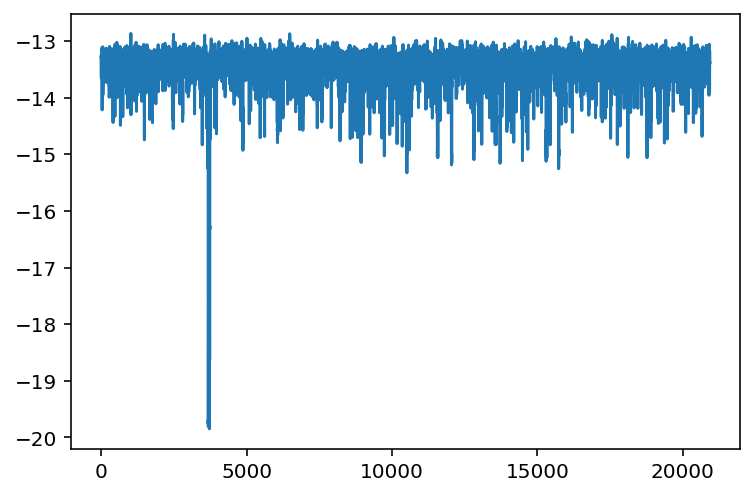

In [114]:
# Make trace-plot to diagnose sampling
plt.plot(chain[burn:, ind])

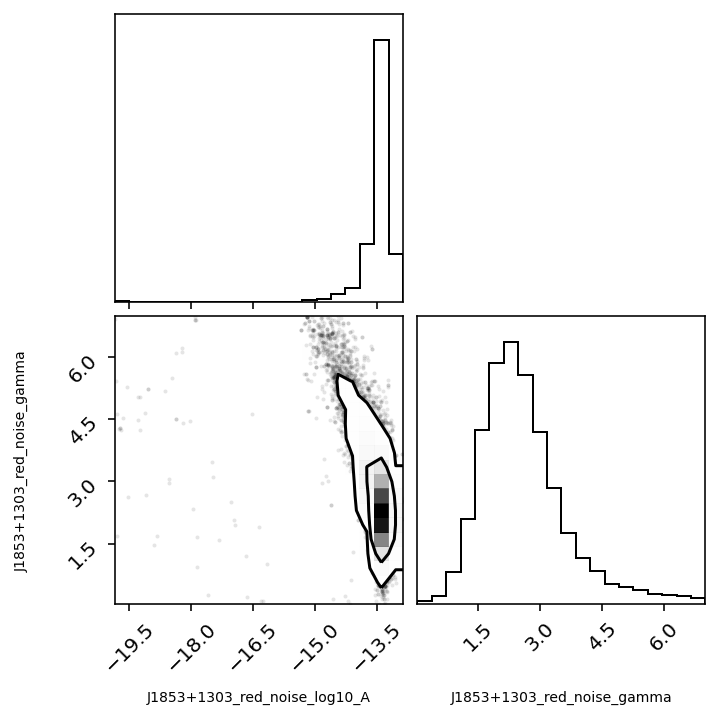

In [115]:
# Make 2d histogram plot for red noise
ind_redA = list(pta.param_names).index(psrstring + '_red_noise_log10_A')
ind_redgam = list(pta.param_names).index(psrstring + '_red_noise_gamma')
fig = corner.corner(chain[burn:, [ind_redA, ind_redgam]], 
                    labels=[psrstring + '_red_noise_log10_A',
                            psrstring + '_red_noise_gamma'],
                            label_kwargs={"fontsize": 7},
                            levels=[0.68,0.95]);

In [121]:
# compare red noise amplitude
print('params_max =',
      params['J1853+1303_red_noise_log10_A'])  # from the noise file
hist = np.histogram(chain[burn:, [ind_redA]],
                          bins=70,
                          density=False)
max_ind = np.argmax(hist[0])
print('our_max =', hist[1][max_ind])  # from our computation

params_max = -13.39744115688417
our_max = -13.36536308395119


In [122]:
# compare red noise gamma
print('params_max =',
      params['J1853+1303_red_noise_gamma'])  # from the noise file
hist = np.histogram(chain[burn:, [ind_redgam]],
                          bins=70,
                          density=False)
max_ind = np.argmax(hist[0])
print('our_max =', hist[1][max_ind])  # from our computation

params_max = 2.4720178742938748
our_max = 2.224466601962412


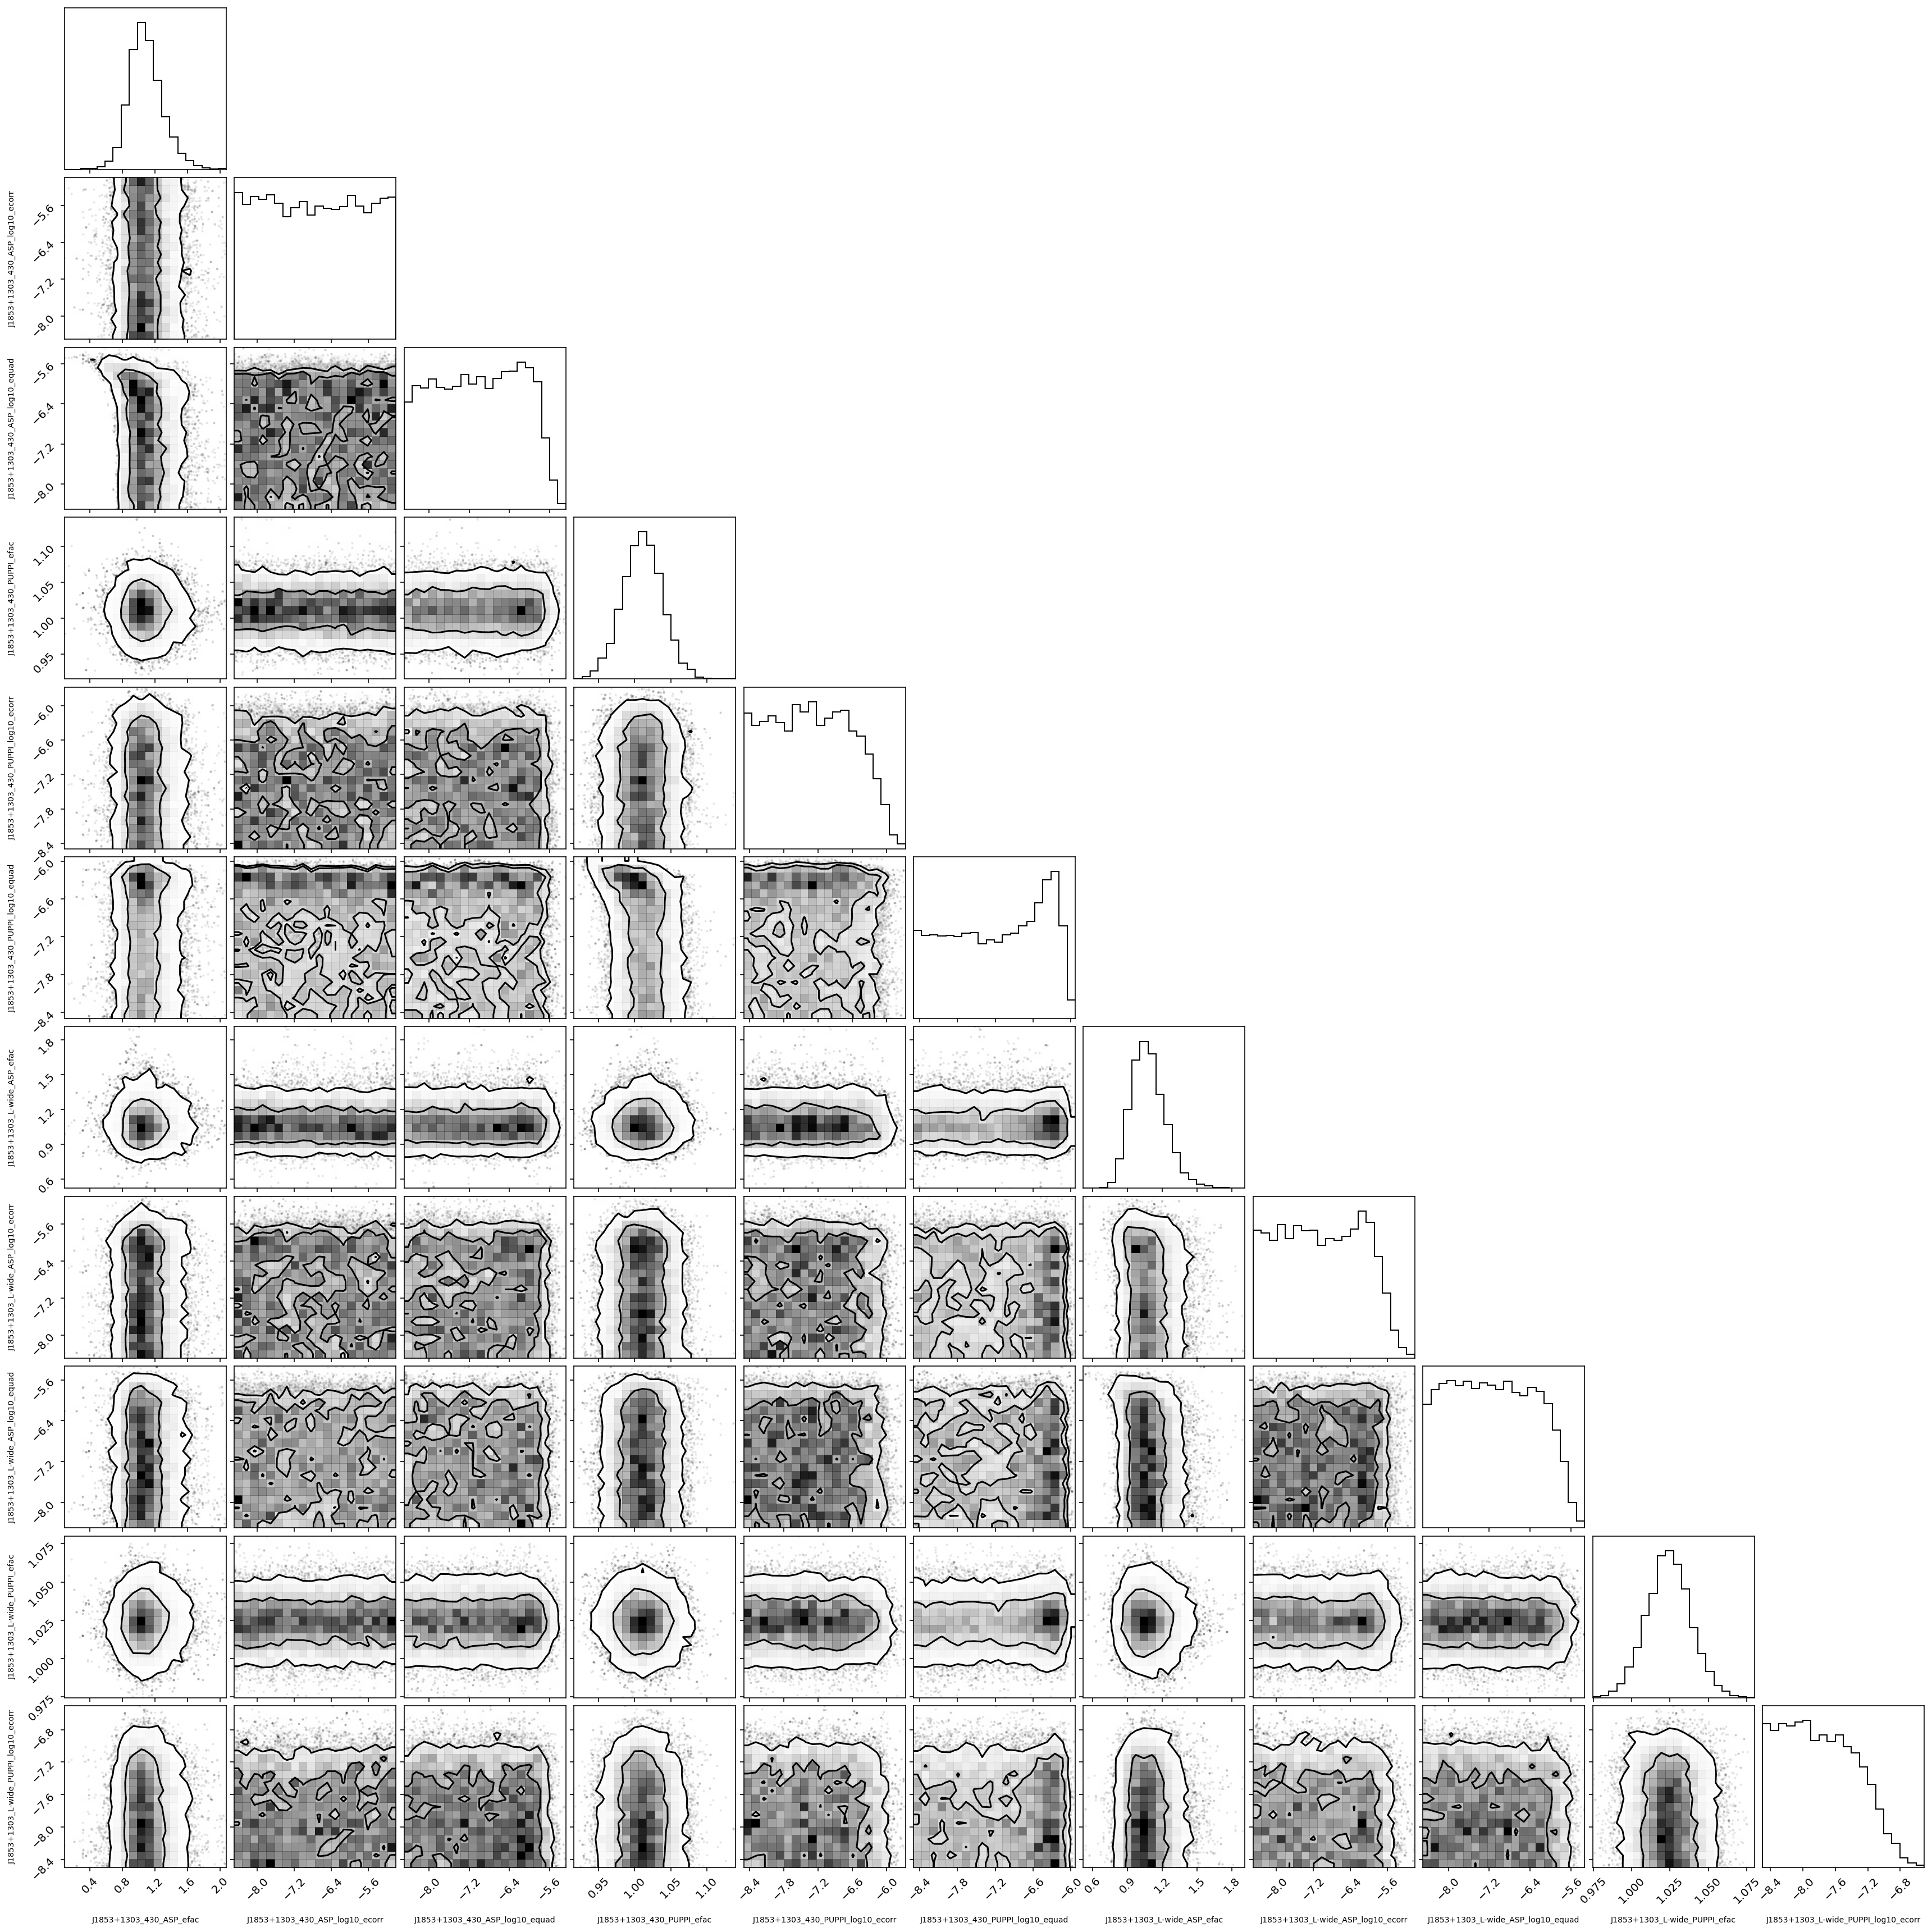

In [124]:
# Make 2d histogram plot for white noise
ind_end = list(pta.param_names).index(psrstring + '_L-wide_PUPPI_log10_equad')
fig = corner.corner(chain[burn:, np.arange(ind_end)],
                    labels=list(pta.param_names[0:ind_end]),
                    label_kwargs={"fontsize": 7},
                    levels=[0.68,0.95]);

In [125]:
# check the white noise parameters against the noisefile
for par in list(pta.param_names[0:ind_end]):
    print('{}_max ='.format(par), params[par])
    hist = np.histogram(chain[burn:, pta.param_names.index(par)],
                          bins=70,
                          density=False)
    max_ind = np.argmax(hist[0])
    print('our_max =', hist[1][max_ind])  # from our computation
    print()

J1853+1303_430_ASP_efac_max = 1.078315248869886
our_max = 0.9995782055606173

J1853+1303_430_ASP_log10_ecorr_max = -6.786182491593548
our_max = -8.499761667533997

J1853+1303_430_ASP_log10_equad_max = -7.0316537983149825
our_max = -6.241206845470427

J1853+1303_430_PUPPI_efac_max = 1.0109631461154447
our_max = 1.0117619063628267

J1853+1303_430_PUPPI_log10_ecorr_max = -7.344038425120731
our_max = -7.60960084938168

J1853+1303_430_PUPPI_log10_equad_max = -7.1227376684628645
our_max = -6.262044831631276

J1853+1303_L-wide_ASP_efac_max = 1.0786110947865066
our_max = 1.0571185534765566

J1853+1303_L-wide_ASP_log10_ecorr_max = -7.0135381645815835
our_max = -6.102068866926019

J1853+1303_L-wide_ASP_log10_equad_max = -7.1547369968726455
our_max = -7.730127581087531

J1853+1303_L-wide_PUPPI_efac_max = 1.0235843088915801
our_max = 1.0227183835512677

J1853+1303_L-wide_PUPPI_log10_ecorr_max = -7.804157398025932
our_max = -8.32893092815917



* This covers the white noise analysis for a single pulsar!
* Next, we move on to the Bayesian analysis of the common red noise process. 
* In the common red noise process analysis we will fix the white noise parameters to their most likely values according to single pulsar white noise runs as performed above.
* These values have been stored in a dictionary in the `channelized_12p5yr_v3_full_noisedict.json` file for the entire PTA.